In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.datasets
import torchvision.transforms 
from datetime import datetime
from model import Siamese_Network
import os, sys
from torch.utils.data import DataLoader, Dataset

import torch 
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image
import PIL.ImageOps    
from torch.utils.data import Dataset

ValueError: module functions cannot set METH_CLASS or METH_STATIC

In [ ]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset, imageFolderAltered, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.imageFolderAltered = imageFolderAltered
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderAltered.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderAltered.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        concatenated = torch.cat((img0, img1), 1)
        imshow(torchvision.utils.make_grid(concatenated))
        
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
class Siamese_Network(nn.Module):
    def __init__(self):
        super(Siamese_Network, self).__init__()

        # convolutional neural network
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )

        # fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256), 
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )
    
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_dist = F.pairwise_distance(output1, output2, keepdim=True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_dist, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_dist, min=0.0), 2))
        return loss_contrastive

In [ ]:

def train(model, device, train_loader, optimizer, epoch, criterion):
    counter = []
    loss_history = []
    iteration_number = 0

    for i, (img0, img1, label) in enumerate(train_loader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        # print("HERE", img0, img1, label)
        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = model(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            print(iteration_number)
            loss_history.append(loss_contrastive.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, i, len(train_loader.dataset),
				100. * i / len(train_loader), loss_contrastive.item()))
        # if iteration_number==:
        #     show_plot(counter, loss_history)



BMP Train set:  Dataset ImageFolder
    Number of datapoints: 4800
    Root location: ../../train_images
LEN:  4800
cuda:0
0


TypeError: Invalid shape (103, 96, 2) for image data

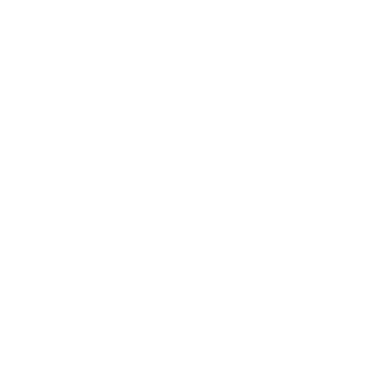

In [ ]:
def main():
    
    directory_train_images = datasets.ImageFolder(root='../../train_images')
    directory_train_altered_images = datasets.ImageFolder(root='../../train_altered-hard')

    directory_test_images = datasets.ImageFolder(root='../../test_images')
    directory_test_altered_images = datasets.ImageFolder(root='../../test_altered-hard')
    transform_train = transforms.Compose([transforms.Resize((103,96)),
                                     transforms.ToTensor()
                                    ])
    
    transform_test = transforms.Compose([transforms.Resize((103,96)),
                                     transforms.ToTensor()
                                    ])
        
    print("BMP Train set: ", directory_train_images)
    trainset = SiameseNetworkDataset(directory_train_images, directory_train_altered_images, transform_train) 
    
    print("LEN: ", len(trainset))
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print(device)
    model = Siamese_Network().to(device)
        
    criterion = ContrastiveLoss()

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    # Create a simple dataloader just for simple visualization
    # vis_dataloader = DataLoader(trainset,
    #                         shuffle=True,
    #                         num_workers=2,
    #                         batch_size=8)

    # # Extract one batch
    # example_batch = next(iter(vis_dataloader))

    # # Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
    # # If the label is 1, it means that it is not the same person, label is 0, same person in both images
    # concatenated = torch.cat((example_batch[0], example_batch[1]),0)

    # imshow(torchvision.utils.make_grid(concatenated))
    # print(example_batch[2].numpy().reshape(-1))

    #######################################################

    for epoch in range(1):
        print(epoch)
        train(model, device, train_loader, optimizer, epoch, criterion)

    # Locate the test dataset and load it into the SiameseNetworkDataset
    siamese_dataset = SiameseNetworkDataset(directory_test_images, directory_test_altered_images, transform=transform_test)
    test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

    # Grab one image that we are going to test
    dataiter = iter(test_dataloader)
    x0, x1, label = next(dataiter)

    # while label!=0:
    #     concatenated = torch.cat((x0, x1), 0)
    #     output1, output2 = model(x0.cuda(), x1.cuda())
    #     euclidean_distance = F.pairwise_distance(output1, output2)[0]
    #     imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
    #     print(label)
    #     x0, x1, label = next(dataiter)
    # concatenated = torch.cat((x0, x1), 0)
    # output1, output2 = model(x0.cuda(), x1.cuda())
    # euclidean_distance = F.pairwise_distance(output1, output2)[0]
    # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
    # print(label)
        
    first = 0
    for i in range(25):
        # Iterate over 5 images and test them with the first image (x0)
        if first>0:
            x0, x1, label = next(dataiter)
        first+=1
        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)
        print(concatenated.size())
        print("label:", label)
        output1, output2 = model(x0.cuda(), x1.cuda())
        print("Outputs: ", output1, output2)
        euclidean_distance = F.pairwise_distance(output1, output2)[0]
        print("euclidean dist:", euclidean_distance)
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
        

if __name__ == "__main__":
    main()